In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import shutil
from pathlib import Path

sys.path.append('../')

import mlflow
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from mlflow.tracking import MlflowClient
from sklearn.model_selection import train_test_split

from scripts import logger
from scripts.env import env_vars
from scripts.evaluate import calculate_metrics
from scripts.utils_mlflow import log_model_info, get_experiment_id
from scripts.utils import read_table_from_db, read_pkl, get_bins, read_yaml, compare_distributions, save_yaml

cp: cannot stat '/home/mle-user/mle_projects/mle-project-sprint-2-v001/notebooks/1_resister_baseline.ipynb': No such file or directory


In [12]:
RUN_NAME_BASELINE = 'baseline'

BASELINE_ARTIFACT_DIR = 'baseline'

Setting up tracking uri and registery uri with a Mlflow client

In [4]:
mlflow.set_tracking_uri(f"http://{env_vars.tracking_server_host}:{env_vars.tracking_server_port}")
mlflow.set_registry_uri(f"http://{env_vars.tracking_server_host}:{env_vars.tracking_server_port}")

client = MlflowClient()

Loading config file and the cleaned data from the remote database

In [5]:
config = read_yaml(Path(f"{env_vars.config_dir}/config.yaml"))

df = read_table_from_db(table_name=config['raw_table_name'])

2024-09-23 13:24:49,800 - mlflow_project - INFO - YAML file ../config/config.yaml has been loaded


2024-09-23 13:24:51,102 - mlflow_project - INFO - Table cleaned_flats has been loaded


Splitting data into train and test subsets with a stratification approach.  
Since it is a regression problem, the target column is binned into several bins  
and the resulting column is used for stratification.

It can be seen, that the distribution of the target column is similar in both train and test subsets.

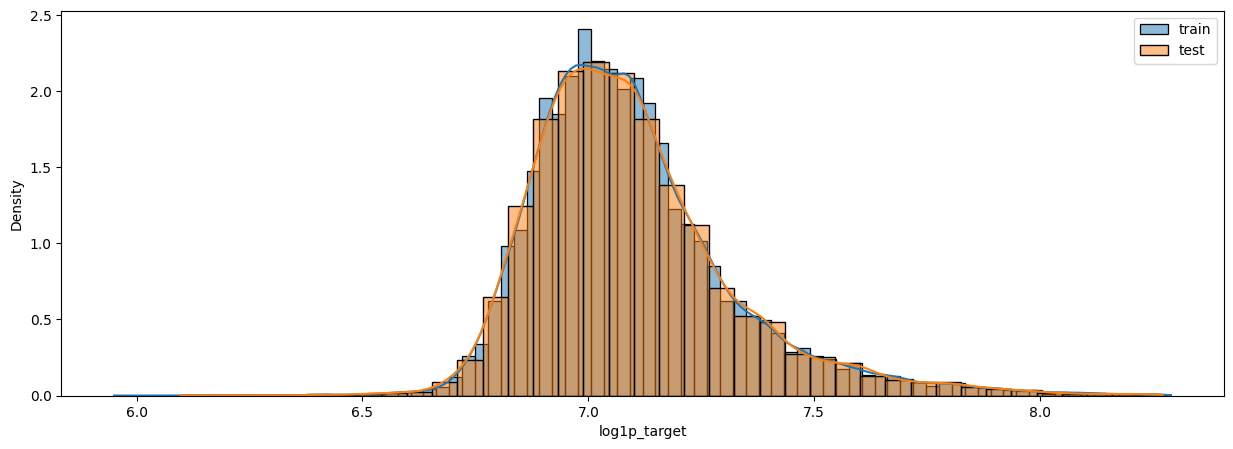

/home/mle-user/mle_projects/mle-project-sprint-2-v001/notebooks/../scripts/utils.py:294: UserWarning: p-value capped: true value larger than 0.25
  res["anderson_ksamp"] = stats.anderson_ksamp([data1, data2]).pvalue


,feature,hue1,hue2,significance_level,ks_2samp.pv,anderson_ksamp.pv,mannwhitneyu.pv,ranksums.pv,ks_2samp.similar,anderson_ksamp.similar,mannwhitneyu.similar,ranksums.similar
0,log1p_target,train,test,0.05,0.999411,0.25,0.912177,0.912179,True,True,True,True


In [6]:
df, df_test = train_test_split(
    df,
    test_size=config["data_split_config"]["test_size"],
    random_state=config["data_split_config"]["random_state"],
    stratify=pd.qcut(df[config["target_col"]], 10, labels=False),
    shuffle=True,
)
df["subset"] = "train"
df_test["subset"] = "test"
df = pd.concat([df, df_test], axis=0)


fig, axs = plt.subplots(1, figsize=(15, 5))
sns.histplot(
    data=df.query(f'subset == "train"')[config["target_col"]],
    kde=True,
    stat="density",
    ax=axs,
    label="train",
    alpha=0.5,
    bins=get_bins(len(df.query(f'subset == "train"'))),
)
sns.histplot(
    data=df.query(f'subset == "test"')[config["target_col"]],
    kde=True,
    stat="density",
    ax=axs,
    label="test",
    alpha=0.5,
    bins=get_bins(len(df.query(f'subset == "test"'))),
)
plt.legend()
plt.show()

compare_distributions(data=df, features=[config['target_col']], hue='subset', are_categorical=False)

Let's save the config and cleaned data with the train-test split into the artifacts folder.

In [7]:
df.to_csv(os.path.join(env_vars.baseline_artifacts_dir, "cleaned_data.csv"), index='drop')
save_yaml(data=config, path=Path(os.path.join(env_vars.baseline_artifacts_dir, "config.yaml")))

2024-09-23 13:24:54,620 - mlflow_project - INFO - Dictionary has been saved to YAML file ../artifacts/baseline/config.yaml


Reading the baseline model from the local directory

In [8]:
baseline = read_pkl(Path('../models/baseline.pkl'))
baseline

2024-09-23 13:24:55,506 - mlflow_project - INFO - Model ../models/baseline.pkl has been loaded


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('binary',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['is_apartment',
                                                   'has_elevator',
                                                   'is_duplicated']),
                                                 ('num', 'passthrough',
                                                  ['id', 'floor',
                                                   'kitchen_area',
                                                   'living_area', 'rooms',
                                                   'total_area', 'build_year',
                                                   'latitude', 'longitude',
                                                   'ceiling_height',
                                                   'flats_count',
                                                   'floors_total']),
                                                 ('non-binary',
                                                  CatBoostEncoder(cols=['building_type_int']),
                                                  ['building_type_int'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7f8e699b0550>)])

Retrieving parameters from the model.
Since the value limit is not that big, the dictionary with parameters will be flattened

In [9]:
params = dict(
    [
        (f"{step_name}__{param_name}", param_value)
        for step_name, step in baseline.named_steps.items()
        for param_name, param_value in step.get_params().items()
    ]
)
params

{'preprocessor__n_jobs': None,
 'preprocessor__remainder': 'drop',
 'preprocessor__sparse_threshold': 0.3,
 'preprocessor__transformer_weights': None,
 'preprocessor__transformers': [('binary',
   OneHotEncoder(drop='if_binary'),
   ['is_apartment', 'has_elevator', 'is_duplicated']),
  ('num',
   'passthrough',
   ['id',
    'floor',
    'kitchen_area',
    'living_area',
    'rooms',
    'total_area',
    'build_year',
    'latitude',
    'longitude',
    'ceiling_height',
    'flats_count',
    'floors_total']),
  ('non-binary',
   CatBoostEncoder(cols=['building_type_int']),
   ['building_type_int'])],
 'preprocessor__verbose': False,
 'preprocessor__verbose_feature_names_out': False,
 'preprocessor__binary': OneHotEncoder(drop='if_binary'),
 'preprocessor__num': 'passthrough',
 'preprocessor__non-binary': CatBoostEncoder(cols=['building_type_int']),
 'preprocessor__binary__categories': 'auto',
 'preprocessor__binary__drop': 'if_binary',
 'preprocessor__binary__dtype': numpy.float64

Making prediction on the test data and calculating metrics

In [10]:
prediction = baseline.predict(df.query('subset == "test"'))
metrics = calculate_metrics(df.query('subset == "test"')[config['target_col']], prediction)
metrics

{'MAE': 2179497.033061224,
 'RMSE': 4300536.543886812,
 'MAPE': 0.1430223604285693,
 'R2': 0.8812041948322492}

Logging artifacts with the model and all necessary information using Mlflow

In [13]:
experiment_id = get_experiment_id(experiment_name=config['experiment_name'], client=client)

with mlflow.start_run(run_name=RUN_NAME_BASELINE, experiment_id=experiment_id) as run:

    # Logging cleaned data and config file
    mlflow.log_artifacts(
        local_dir=env_vars.baseline_artifacts_dir,
        artifact_path=BASELINE_ARTIFACT_DIR
    )

    # Logging scripts
    mlflow.log_artifacts(
        local_dir='../scripts',
        artifact_path=f'{BASELINE_ARTIFACT_DIR}/scripts'
    )

    # Logging notebook
    mlflow.log_artifact(
        local_path=os.path.join(os.getcwd(), '1_register_baseline.ipynb'),
        artifact_path=BASELINE_ARTIFACT_DIR
    )
    logger.info(f'Logged artifacts from baseline stage')

    # Logging the model
    log_model_info(
        model=baseline,
        client=client,
        registry_model_name=config['model_registry_name'],
        model_loader=mlflow.sklearn,
        input_example=df.query('subset == "test"')[:10],
        prediction=prediction[:10],
        metrics=metrics,
        params=params,
        model_tags={'model_type': 'baseline'},
        metadata=None,
    )

2024-09-23 13:25:47,275 - mlflow_project - INFO - Experiment 'flat_price_prediction' exists


2024-09-23 13:25:48,475 - mlflow_project - INFO - Logged artifacts from baseline stage
2024-09-23 13:25:48,520 - mlflow_project - INFO - Metrics for model flat_price_prediction_model has been logged
2024-09-23 13:25:48,575 - mlflow_project - INFO - Paremeters for model flat_price_prediction_model has been logged


/home/mle-user/mle_projects/mle-project-sprint-2-v001/.venv/lib/python3.10/site-packages/mlflow/models/signature.py:212: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input) if model_input is not None else None


2024-09-23 13:25:49,246 - mlflow_project - INFO - Model flat_price_prediction_model has been logged


Successfully registered model 'flat_price_prediction_model'.
Created version '1' of model 'flat_price_prediction_model'.


In [14]:
print('experiment_name =', config['experiment_name'])
print('experiment_id =', experiment_id)

experiment_name = flat_price_prediction
experiment_id = 11
